# Two Dimensional Hidden Fractal Interpolation 

Consider the data points $(x_i, y_i), \; i = 1, 2, \ldots, N$ triangulized over a triangular domain $\Omega \subset \mathbb{R}^n$. Associated with the data point $(xi, yi)$ we consider real values $z_i \in \mathbb{R}, \; i = 1, 2, \ldots, N$. In addition, we consider additional real data values $t_i \; i = 1, 2, \ldots, N$. Our aim is to find and interpolation function, i.e., interpolant $f: \Omega \mapsto \mathbb{R}^2$ such that $(z_i, t_i) = f(x_i, y_i), \; i = 1, 2, \ldots, N$.

Consider the iterated function system $\mathcal{I} = \{\Omega \times \mathbb{R}^n; w_n, n = 1, 2, \ldots, K\}$ where 
$$
w_n(x, y, z, t) = 
\begin{bmatrix} 
    \alpha_1^n & \alpha_2^n & 0 & 0 \\ 
    \alpha_3^n & \alpha_4^n & 0 & 0 \\ 
    \alpha_5^n & \alpha_6^n & \alpha_7^n & \alpha_8^n \\ 
    \alpha_9^n & \alpha_{10}^n & \alpha_{11}^n & \alpha_{12}^n 
\end{bmatrix}
\begin{bmatrix}
    x \\ y \\ z \\ t 
\end{bmatrix}
+ 
\begin{bmatrix} 
    \beta_1^n \\
    \beta_2^n \\
    \beta_3^n \\
    \beta_4^n
\end{bmatrix}
$$
We can divide the transformation $w_n, \; n = 1, 2, \ldots, K$ as follows,
$$
w_n(x, y, z, t) = (L_n(x, y), F_n(x, y, z, t))
$$
where 
$$
L_n(x, y) = 
\begin{bmatrix} 
    \alpha_1^n & \alpha_2^n \\ 
    \alpha_3^n & \alpha_4^n 
\end{bmatrix}
\begin{bmatrix}
    x \\ y 
\end{bmatrix}
+ 
\begin{bmatrix} 
    \beta_1^n \\
    \beta_2^n 
\end{bmatrix}
$$
and 
$$
F_n(x, y, z, t) = 
\begin{bmatrix} 
    \alpha_5^n & \alpha_6^n & \alpha_7^n \alpha_8^n \\
    \alpha_9^n & \alpha_{10}^n & \alpha_{11}^n \alpha_{12}^n \\
\end{bmatrix}
\begin{bmatrix}
    x \\ y \\ z \\ t 
\end{bmatrix}
+ 
\begin{bmatrix}
    \beta_n^3 \\ \beta_n^4
\end{bmatrix}
$$
Given the free parameters $\alpha_7^n, \alpha_8^n, \alpha_{10}^n, \alpha_{12}^n, \; n = 1, \ldots, K$, the remaining coefficients of the transformations $w_n, \; n = 1, 2, \ldots, K$ can be found from the boundary conditions, 
$$
\begin{aligned} 
L_n(\tilde{x}_j, \tilde{y}_j) &= (x_k, y_k) \quad k = 1, 2, \ldots, K \quad j = 1, 2, 3 \\
F_n(\tilde{x}, \tilde{y}, \tilde{z}, \tilde{t}) &= (z_k, t_k) \quad k = 1, 2, \ldots, K \quad j = 1, 2, 3
\end{aligned}
$$
where the $\{(\tilde{x}_j, \tilde{y}_j), \; j = 1, 2, 3\}$ are the set of the vertex points of the interpolation $\Omega$ and $\{(x_j, y_j), \; j = 1, 2, 3\}$ are the set of vertex points of the triangle $\Omega_k \; k = 1, 2, \ldots, K$ where $K$ is the number of triangles in $\Omega$. Here the free variables $t_n, \; n = 1, 2, \ldots, N$ and the $\alpha_7^n, \alpha_8^n, \alpha_{10}^n, \alpha_{12}^n$ are called the *hidden variables*.

Then the graph of the interpolant $f$ is the attractor of the IFS $\mathcal{I}$. Furthermore, the interpolant $f$ is the fixed of a mapping $Tf: \mathbb{F} \mapsto \mathbb{F}$ where $\mathbb{F}$ is the set of continuous functions $g: \Omega \mapsto \mathbb{R}^2$ such that 
$$
Tf(x, y) = F_n(L_n^{-1}(x, y), f(L_n^{-1}(x, y)))
$$

In [8]:
# Two dimensional hidden interpolation 

using FractalTools
using Triangulation
using PyPlot 
using Statistics

datapath = joinpath(dirname(dirname(pathof(FractalTools))),  "data/gmsh_data")
filename = "t3.msh"

# Read domain file.
domain = read_mesh(joinpath(datapath, filename))
scale_factor = 1 / 10  # Rescale the domain.
for node in domain.nodes
    node.x /= scale_factor
    node.y /= scale_factor
end
domains = triangular_partition(domain)
regions = gmsh2matplotlibtri.(domains)

# Compute z-values on domain points.
func(x, y) = [
    x^2 + y^2,
    x^2 - y^2
]
number_of_regions = length(regions)
z = Vector{Vector}(undef, number_of_regions)
t = Vector{Vector}(undef, number_of_regions)
for k = 1 : number_of_regions
    z[k] = getindex.(func.(regions[k].x, regions[k].y), 1)
    t[k] = getindex.(func.(regions[k].x, regions[k].y), 2)
end

# Refine region to evaluate interpolated function
subdiv = 2
x, y = refine(gmsh2matplotlibtri(domain), subdiv, true)

# Compute initial and real values.
func0(xi, yi) = [0., 0.]

# Perform interpolation.
α7, α8, α11, α12 = fill(0.001, 4)
interpolant, coeffs = hiddenfis(regions, z, t, α7=α7, α8=α8, α11=α11, α12=α12, func0=func0, num_iter=10, get_coeffs=true)

# Interpolation and error
real_values = func.(x, y)
real_values_z = getindex.(real_values, 1)
real_values_t = getindex.(real_values, 2)
interpolated_values = interpolant.(x, y)
interpolated_values_z = getindex.(interpolated_values, 1)
interpolated_values_t = getindex.(interpolated_values, 2)
absolute_error_z = abs.(real_values_z - interpolated_values_z)
absolute_error_t = abs.(real_values_t - interpolated_values_t)
relative_error_z = absolute_error_z ./ (abs.(real_values_z .+ eps())) * 100
relative_error_t = absolute_error_t ./ (abs.(real_values_t .+ eps())) * 100
frerr_z = mean(absolute_error_z.^2)
frerr_t = mean(absolute_error_t.^2)


0.8775772583520092

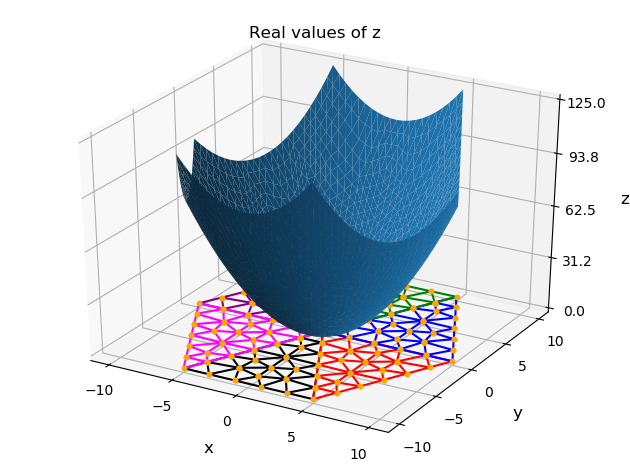

In [18]:
# Plot real values 
xd = xcoords(domain)
yd = ycoords(domain)
ztd = func.(xd, yd)
zd = getindex.(ztd, 1)
td = getindex.(ztd, 2)
minx, meanx, maxx = minimum(x), mean(x), maximum(x)
miny, meany, maxy = minimum(y), mean(y), maximum(y)

plot_trisurf(x, y, real_values_z)
colours = ["black", "red", "blue", "green", "purple", "magenta"]
for (color, region) in zip(colours, regions)
    triplot(region, color=color)
    plot(region.x, region.y, ".", color="orange")
end
title("Real values of z")
xlabel("x", labelpad=10, fontsize=12)
ylabel("y", labelpad=10, fontsize=12)
zlabel("z", labelpad=10, fontsize=12)
xticks(range(minx, maxx, length=5))
yticks(range(miny, maxy, length=5))
zticks(range(minimum(real_values_z), maximum(real_values_z), length=5))
tight_layout()

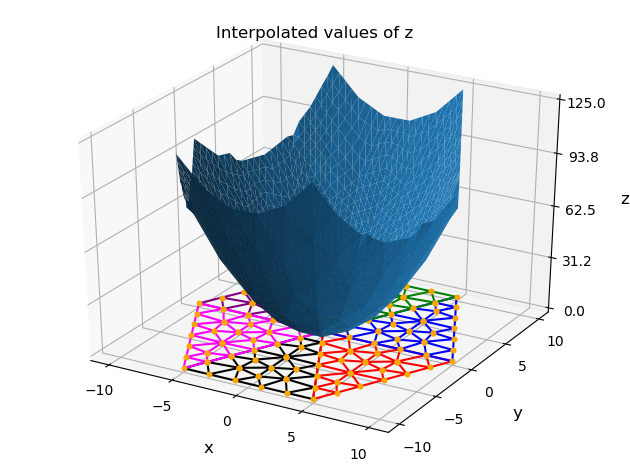

In [19]:
plot_trisurf(x, y, interpolated_values_z)
colours = ["black", "red", "blue", "green", "purple", "magenta"]
for (color, region) in zip(colours, regions)
    triplot(region, color=color)
    plot(region.x, region.y, ".", color="orange")
end
title("Interpolated values of z")
xlabel("x", labelpad=10, fontsize=12)
ylabel("y", labelpad=10, fontsize=12)
zlabel("z", labelpad=10, fontsize=12)
xticks(range(minx, maxx, length=5))
yticks(range(miny, maxy, length=5))
zticks(range(minimum(interpolated_values_z), maximum(interpolated_values_z), length=5))
tight_layout()

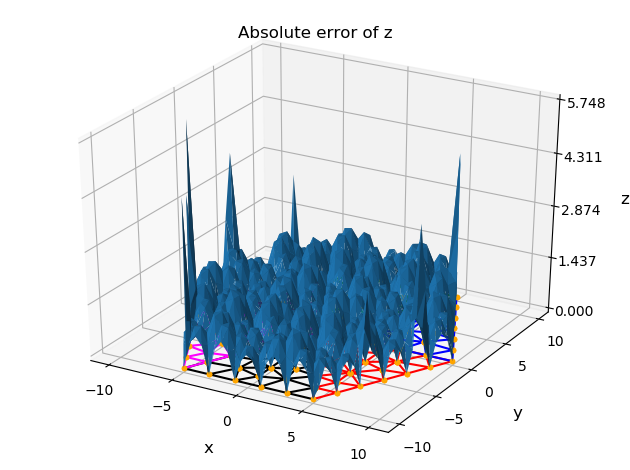

In [21]:
# Interpolated values 
plot_trisurf(x, y, absolute_error_z)
colours = ["black", "red", "blue", "green", "purple", "magenta"]
for (color, region) in zip(colours, regions)
    triplot(region, color=color)
    plot(region.x, region.y, ".", color="orange")
end
title("Absolute error of z")
xlabel("x", labelpad=10, fontsize=12)
ylabel("y", labelpad=10, fontsize=12)
zlabel("z", labelpad=10, fontsize=12)
xticks(range(minx, maxx, length=5))
yticks(range(miny, maxy, length=5))
zticks(range(minimum(absolute_error_z), maximum(absolute_error_z), length=5))
tight_layout()

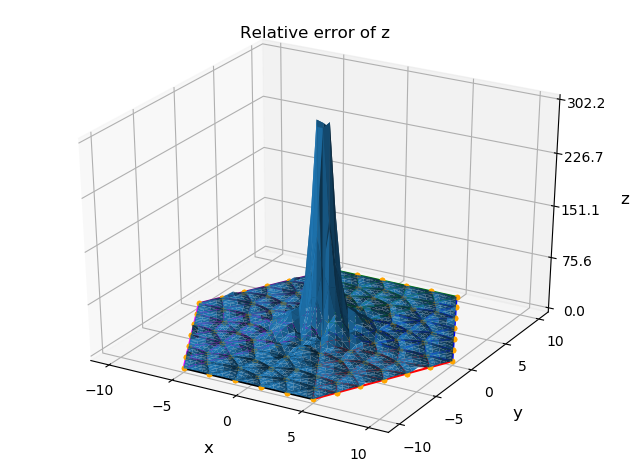

In [22]:
plot_trisurf(x, y, relative_error_z)
colours = ["black", "red", "blue", "green", "purple", "magenta"]
for (color, region) in zip(colours, regions)
    triplot(region, color=color)
    plot(region.x, region.y, ".", color="orange")
end
title("Relative error of z") 
xlabel("x", labelpad=10, fontsize=12)
ylabel("y", labelpad=10, fontsize=12)
zlabel("z", labelpad=10, fontsize=12)
xticks(range(minx, maxx, length=5))
yticks(range(miny, maxy, length=5))
zticks(range(minimum(relative_error_z), maximum(relative_error_z), length=5))
tight_layout()

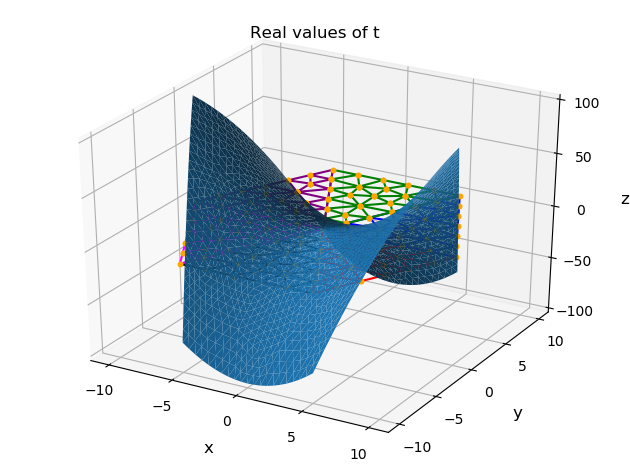

In [25]:
plot_trisurf(x, y, real_values_t)
coluors = ["black", "red", "blue", "green", "purple", "magenta"]
for (color, region) in zip(coluors, regions)
    triplot(region, color=color)
    plot(region.x, region.y, ".", color="orange")
end
title("Real values of t")
xlabel("x", labelpad=10, fontsize=12)
ylabel("y", labelpad=10, fontsize=12)
zlabel("z", labelpad=10, fontsize=12)
xticks(range(minx, maxx, length=5))
yticks(range(miny, maxy, length=5))
zticks(range(minimum(real_values_t), maximum(real_values_t), length=5))
tight_layout()

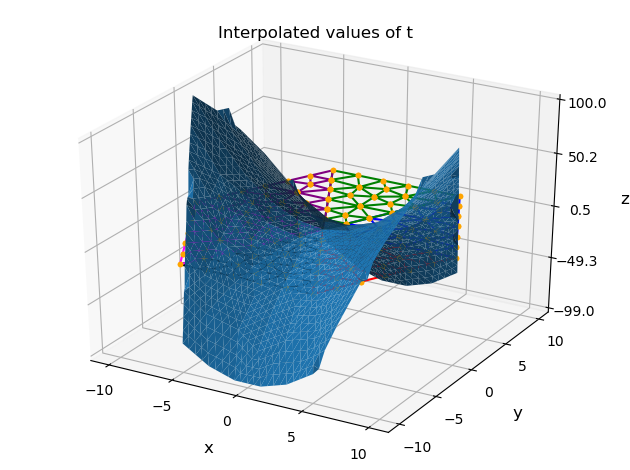

In [26]:
plot_trisurf(x, y, interpolated_values_t)
colours = ["black", "red", "blue", "green", "purple", "magenta"]
for (color, region) in zip(colours, regions)
    triplot(region, color=color)
    plot(region.x, region.y, ".", color="orange")
end
title("Interpolated values of t")
xlabel("x", labelpad=10, fontsize=12)
ylabel("y", labelpad=10, fontsize=12)
zlabel("z", labelpad=10, fontsize=12)
xticks(range(minx, maxx, length=5))
yticks(range(miny, maxy, length=5))
zticks(range(minimum(interpolated_values_t), maximum(interpolated_values_t), length=5))
tight_layout()

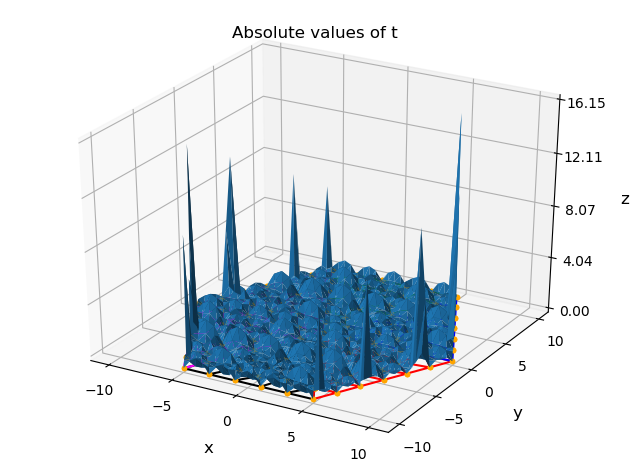

In [28]:
plot_trisurf(x, y, absolute_error_t)
colours = ["black", "red", "blue", "green", "purple", "magenta"]
for (color, region) in zip(colours, regions)
    triplot(region, color=color)
    plot(region.x, region.y, ".", color="orange")
end
title("Absolute values of t")
xlabel("x", labelpad=10, fontsize=12)
ylabel("y", labelpad=10, fontsize=12)
zlabel("z", labelpad=10, fontsize=12)
xticks(range(minx, maxx, length=5))
yticks(range(miny, maxy, length=5))
zticks(range(minimum(absolute_error_t), maximum(absolute_error_t), length=5))
tight_layout()

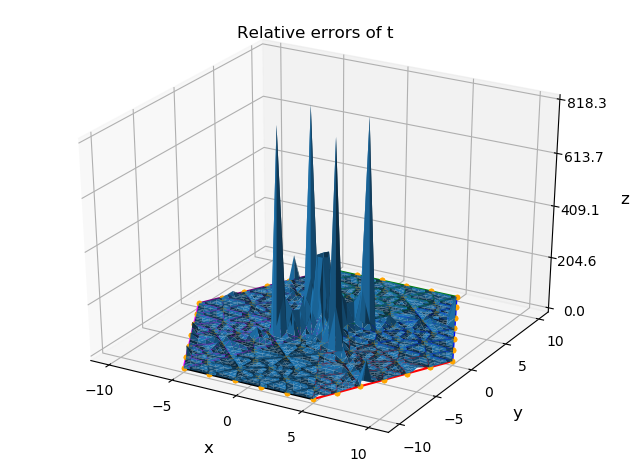

In [30]:
plot_trisurf(x, y, relative_error_t)
colours = ["black", "red", "blue", "green", "purple", "magenta"]
for (color, region) in zip(colours, regions)
    triplot(region, color=color)
    plot(region.x, region.y, ".", color="orange")
end
title("Relative errors of t")
xlabel("x", labelpad=10, fontsize=12)
ylabel("y", labelpad=10, fontsize=12)
zlabel("z", labelpad=10, fontsize=12)
xticks(range(minx, maxx, length=5))
yticks(range(miny, maxy, length=5))
zticks(range(minimum(relative_error_t), maximum(relative_error_t), length=5))
tight_layout()